In [1]:
import numpy as np
import scipy

import cupy as cp
import cupyx.scipy

import astropy.units as u
from astropy.io import fits
from matplotlib.patches import Rectangle, Circle
from pathlib import Path
from IPython.display import clear_output, display, HTML
display(HTML("<style>.container { width:90% !important; }</style>")) # just making the notebook cells wider

from importlib import reload
import time

import logging, sys
poppy_log = logging.getLogger('poppy')
poppy_log.setLevel('DEBUG')
logging.basicConfig(stream=sys.stdout, level=logging.INFO)

poppy_log.disabled = True

import warnings
warnings.filterwarnings("ignore")

import ray
if not ray.is_initialized():
    ray.init(log_to_driver=False)

import wfsc_tests as wfsc
wfsc.math_module.update_np(cp)
wfsc.math_module.update_scipy(cupyx.scipy)

from wfsc_tests.math_module import xp, _scipy, ensure_np_array

import cgi_phasec_poppy

# iefc_dir = Path('/groups/douglase/kians-data-files/roman-cgi-iefc-data')
iefc_dir = Path('/home/kianmilani/Projects/roman-cgi-iefc-data')

dm1_flat = 2*fits.getdata(cgi_phasec_poppy.data_dir/'dm-acts'/'flatmaps'/'hlc_flattened_dm1.fits')
dm2_flat = 2*fits.getdata(cgi_phasec_poppy.data_dir/'dm-acts'/'flatmaps'/'hlc_flattened_dm2.fits')

2023-07-12 15:51:41,843	INFO worker.py:1636 -- Started a local Ray instance.


INFO:numexpr.utils:Note: NumExpr detected 64 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


[38707575.47272583 39321120.8208112  39547077.1074424  39943806.87193675
 39965070.57571509] ph / (s m2)


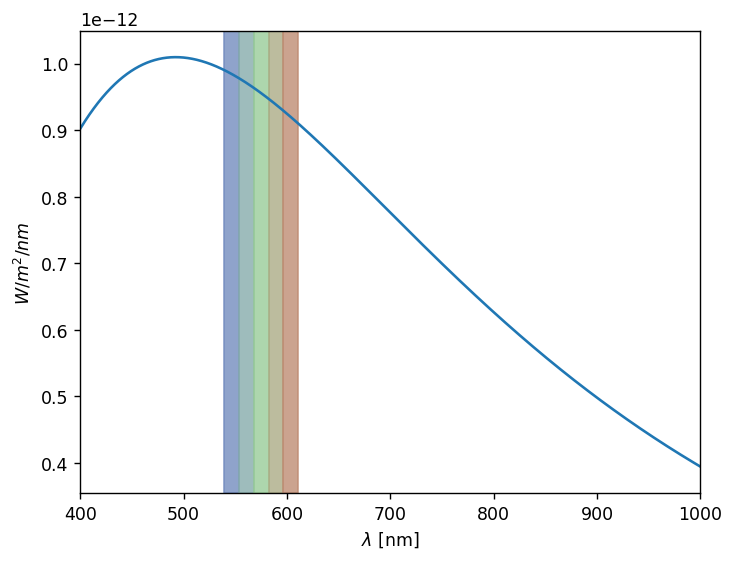

In [2]:
reload(cgi_phasec_poppy.source_flux)

wavelength_c = 575e-9*u.m

nlam = 5
bandwidth = 0.10
minlam = wavelength_c * (1 - bandwidth/2)
maxlam = wavelength_c * (1 + bandwidth/2)
wavelengths = np.linspace( minlam, maxlam, nlam )

from astropy.constants import h, c, k_B, R_sun

uma47 = cgi_phasec_poppy.source_flux.SOURCE(wavelengths=wavelengths,
                                            temp=5887*u.K,
                                            distance=14.06*u.parsec,
                                            diameter=2*1.172*R_sun)

uma47.plot_spectrum()

source_fluxes = uma47.calc_fluxes()
print(source_fluxes)

In [3]:
reload(cgi_phasec_poppy.cgi)
reload(cgi_phasec_poppy.parallelized_cgi)

rayCGI = ray.remote(cgi_phasec_poppy.cgi.CGI) # make a ray actor class from the original CGI class  

wavelength_c = 575e-9*u.m

kwargs = {
    'cgi_mode':'hlc',
    'use_pupil_defocus':True,
    'use_opds':True,
    'polaxis':10,
}

actors = []
for i in range(nlam):
    actors.append(rayCGI.options(num_cpus=2, num_gpus=1/nlam).remote(**kwargs))
    actors[i].setattr.remote('wavelength', wavelengths[i])
    actors[i].setattr.remote('source_flux', source_fluxes[i])

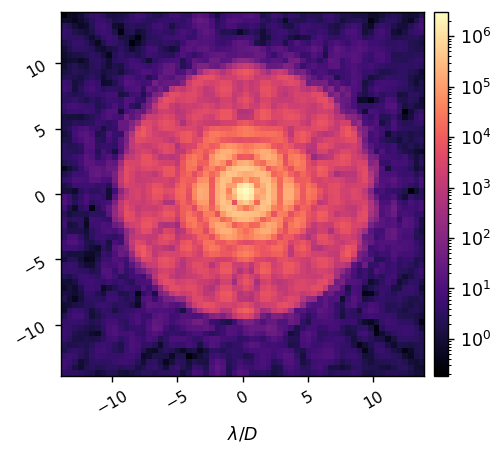

2981884.6766394516

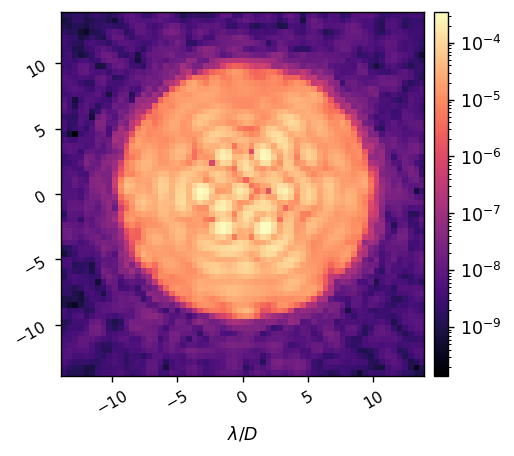

In [4]:
reload(cgi_phasec_poppy.parallelized_cgi)
mode = cgi_phasec_poppy.parallelized_cgi.ParallelizedCGI(actors=actors)

mode.set_dm1(dm1_flat)
mode.set_dm2(dm2_flat)

mode.set_actor_attr('use_fpm',False)
ref_unocc_im = mode.snap()
wfsc.imshow1(ref_unocc_im, pxscl=mode.psf_pixelscale_lamD, xlabel='$\lambda/D$', lognorm=True)

max_ref = ref_unocc_im.get().max()
display(max_ref)

mode.set_actor_attr('use_fpm',True)
mode.Iref = max_ref
ref_im = mode.snap()
wfsc.imshow1(ref_im, pxscl=mode.psf_pixelscale_lamD, xlabel='$\lambda/D$', lognorm=True)

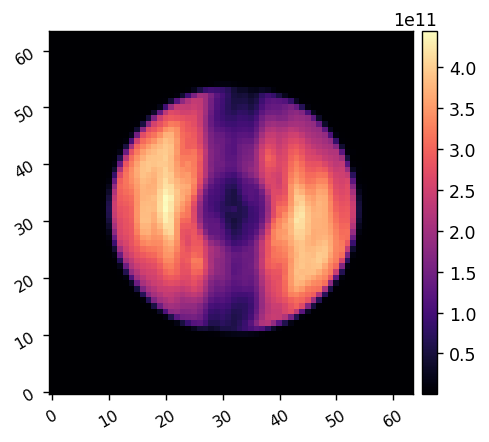

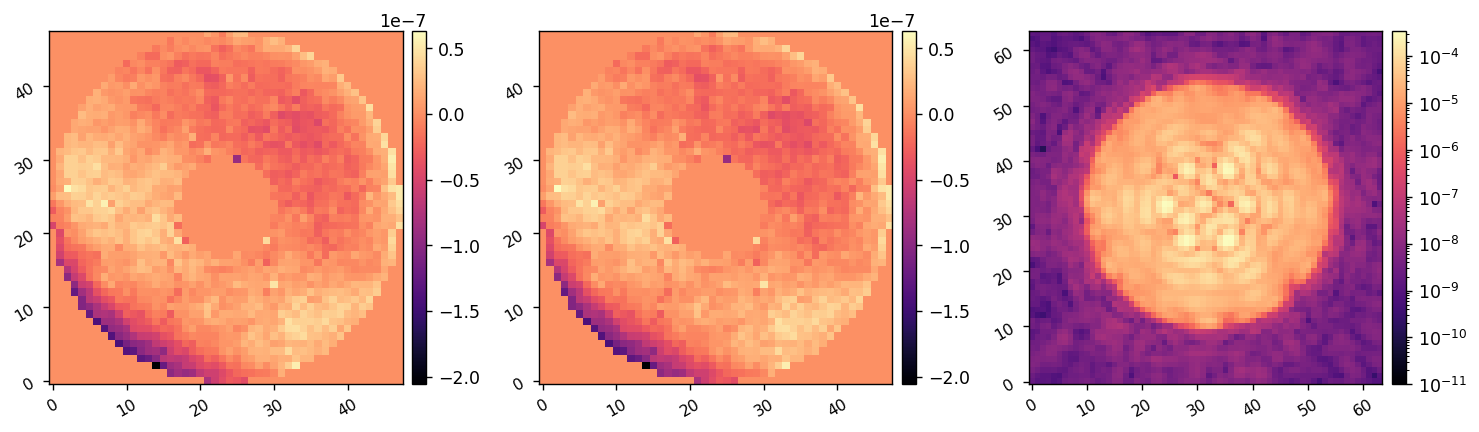

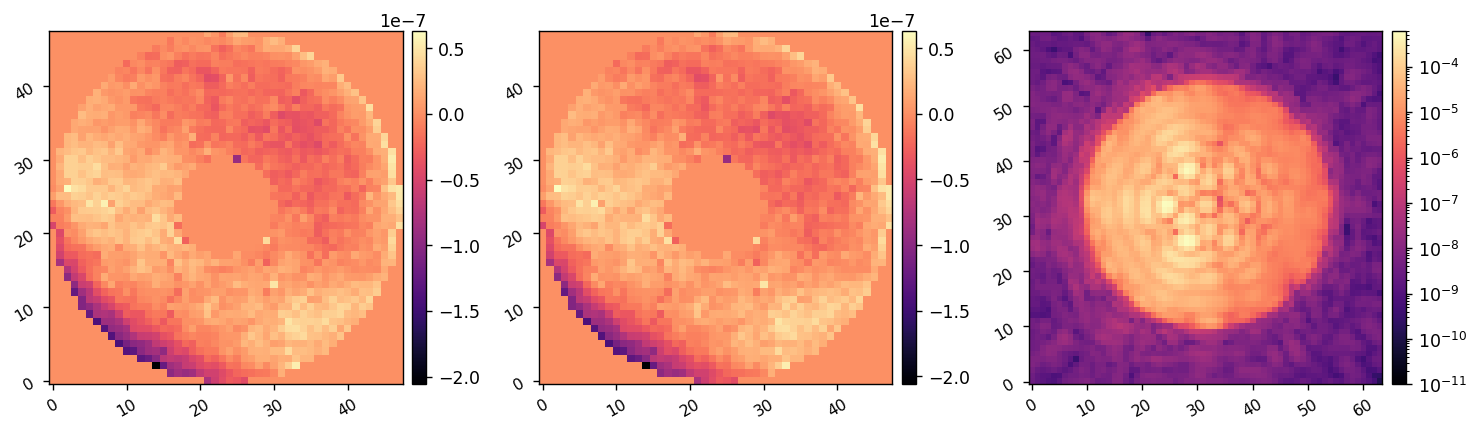

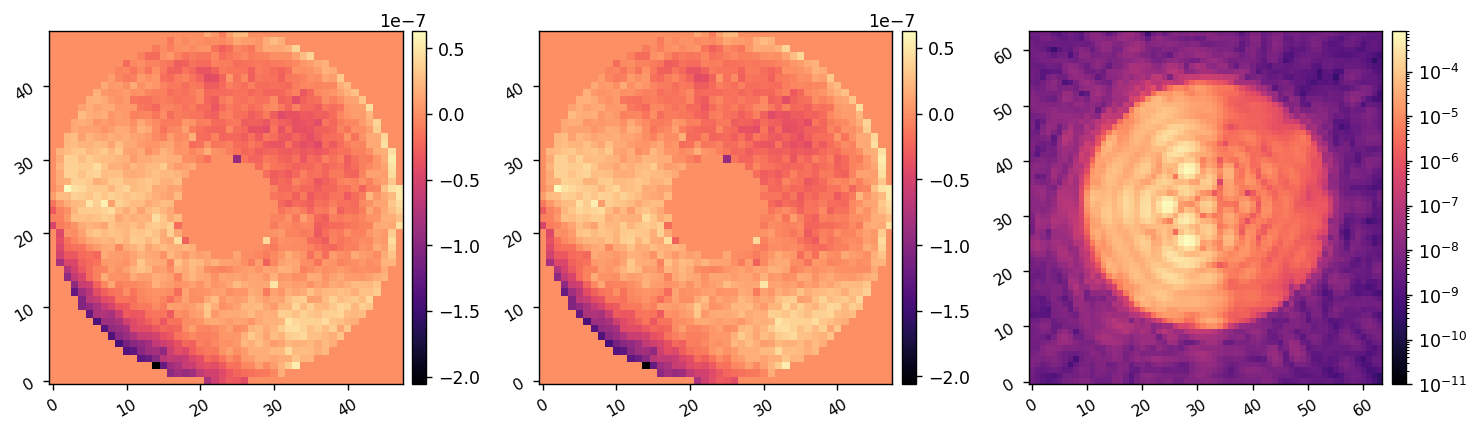

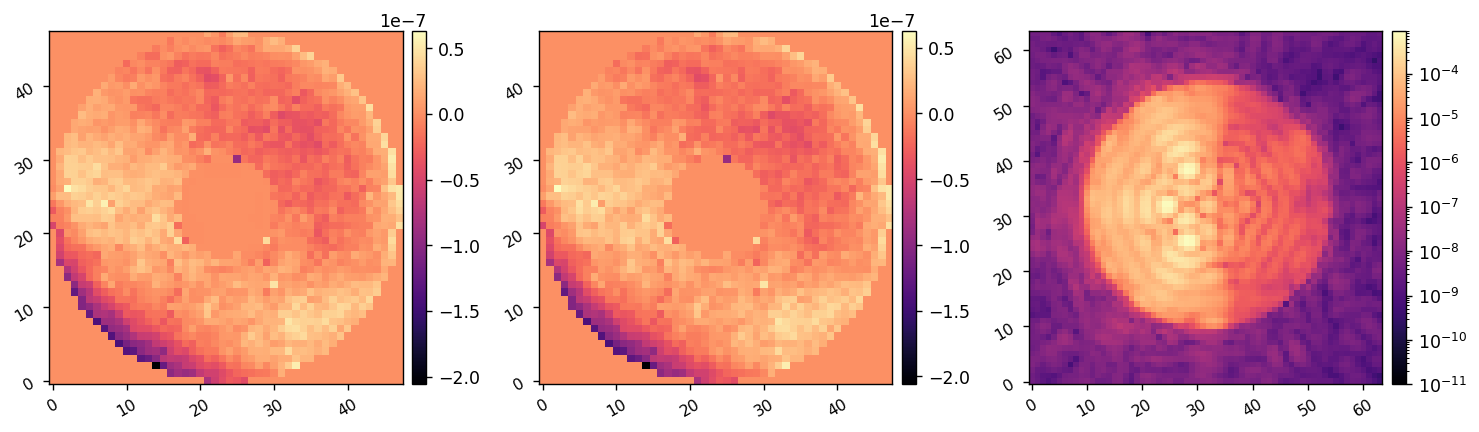

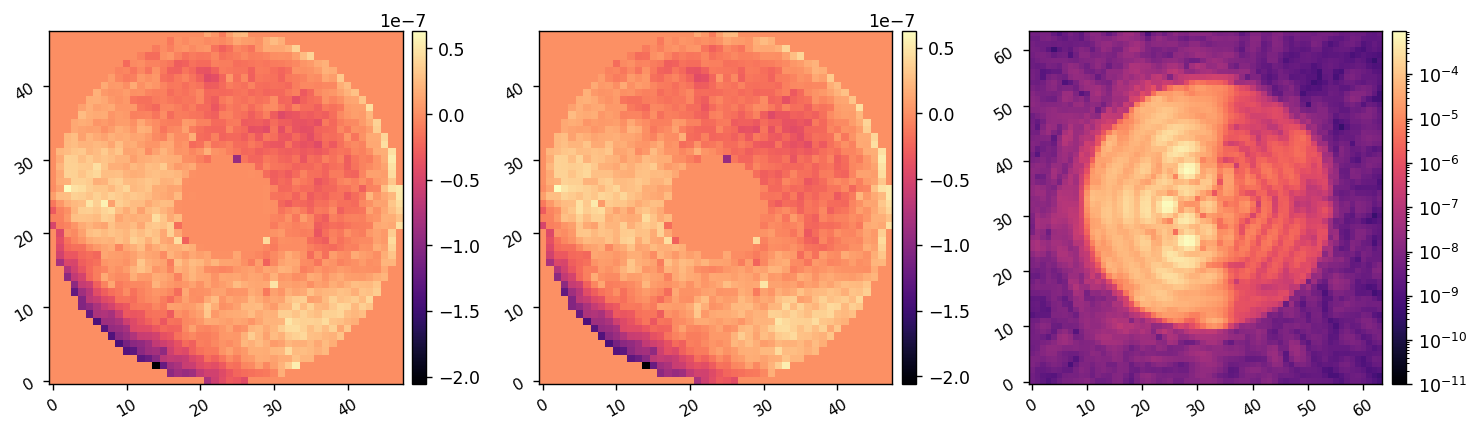

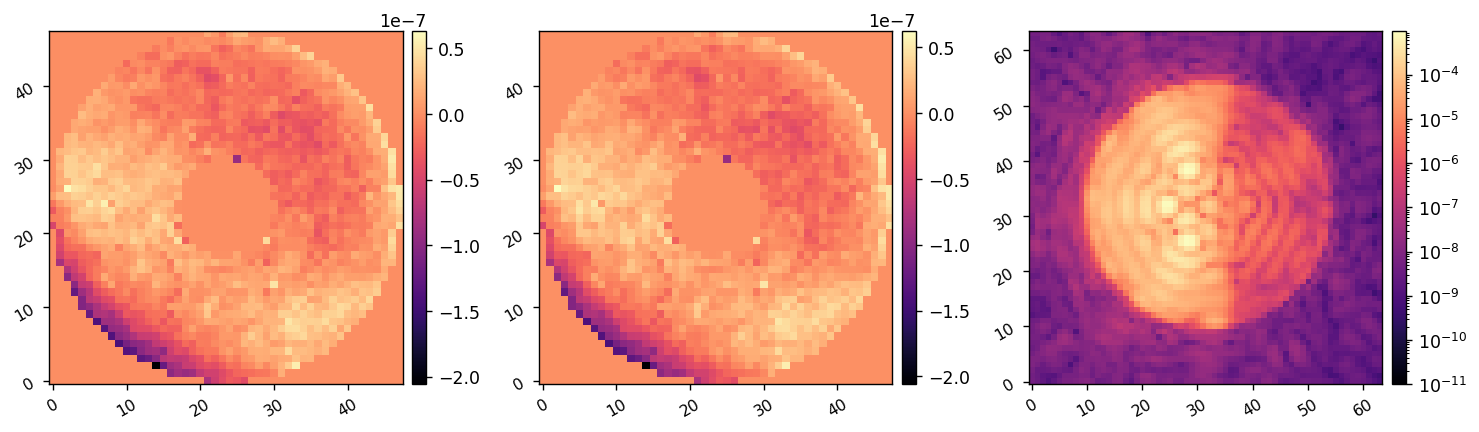

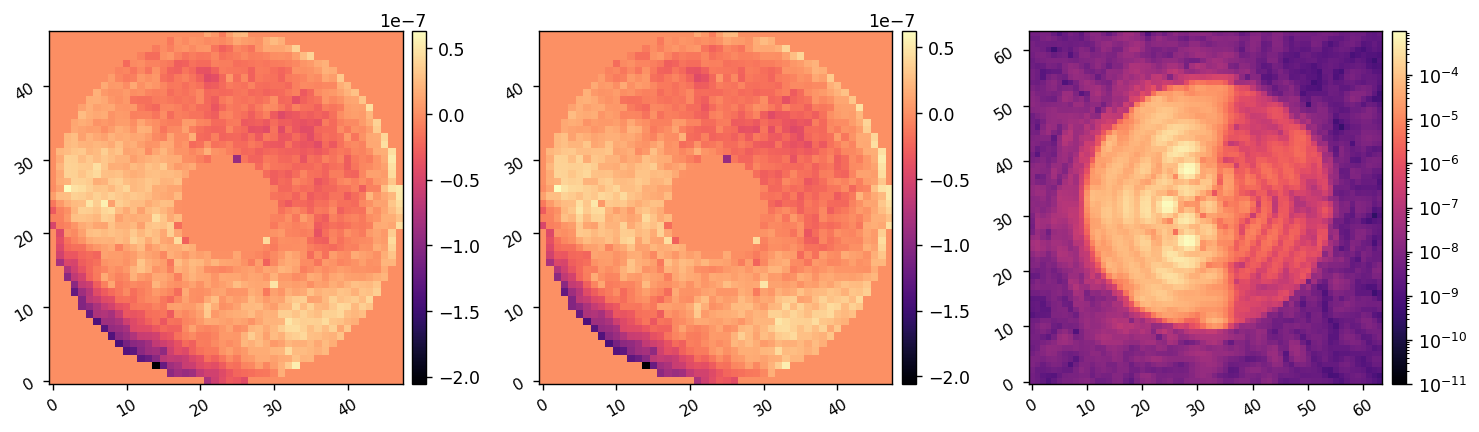

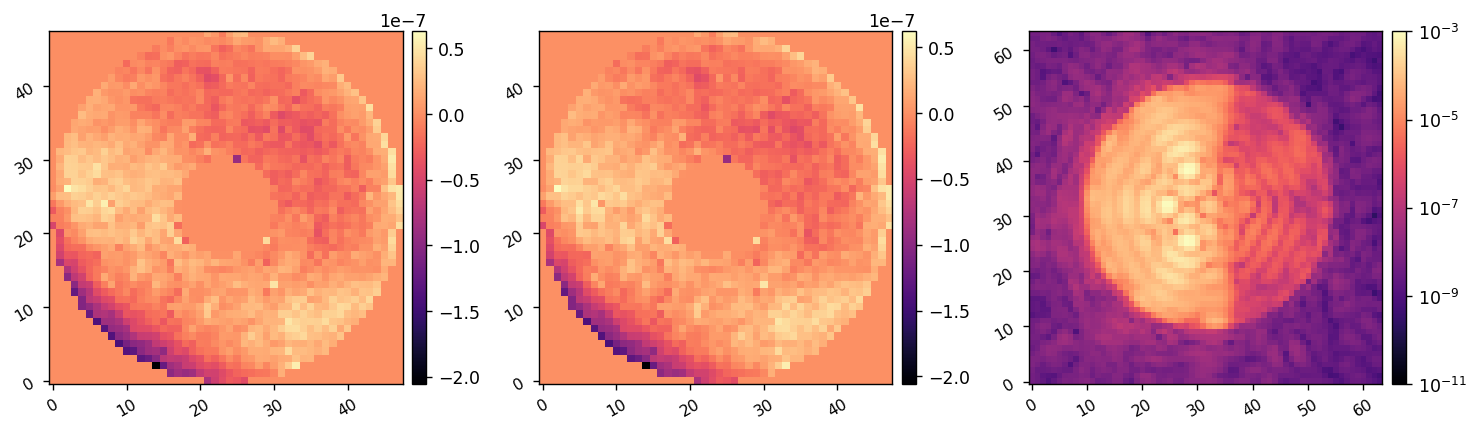

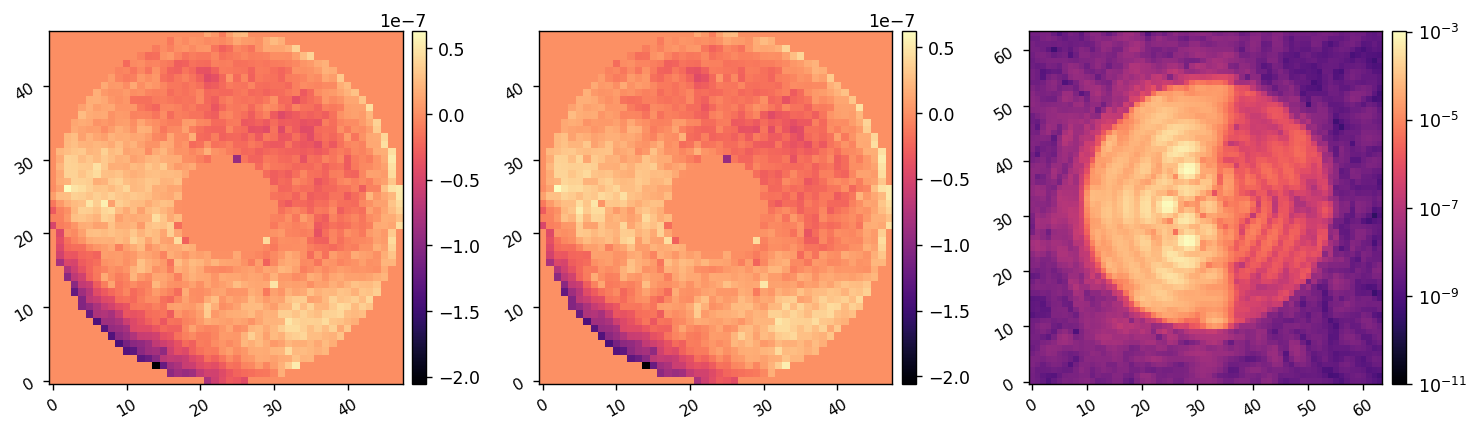

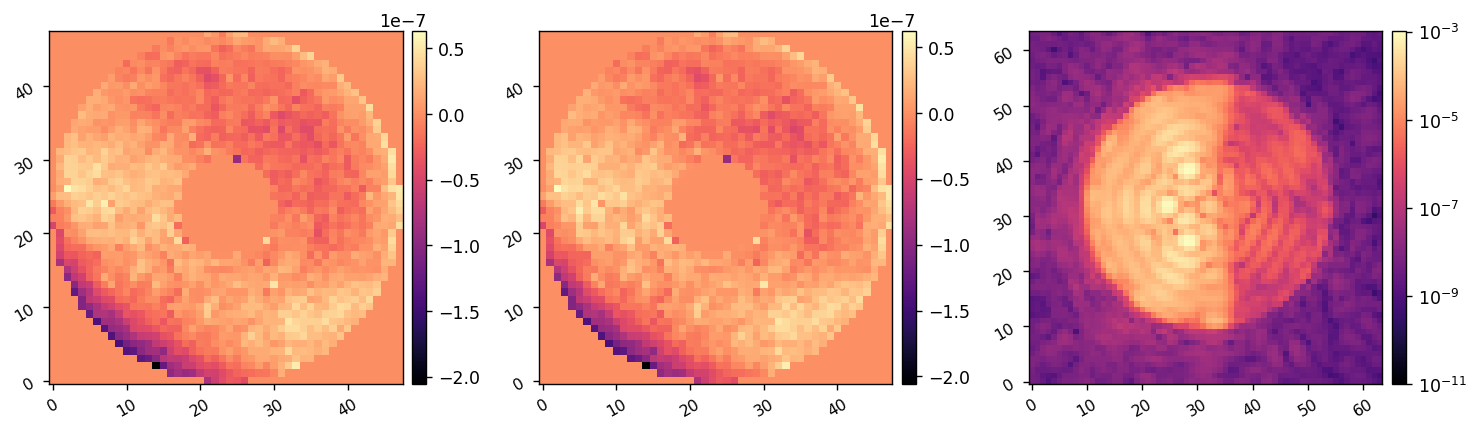

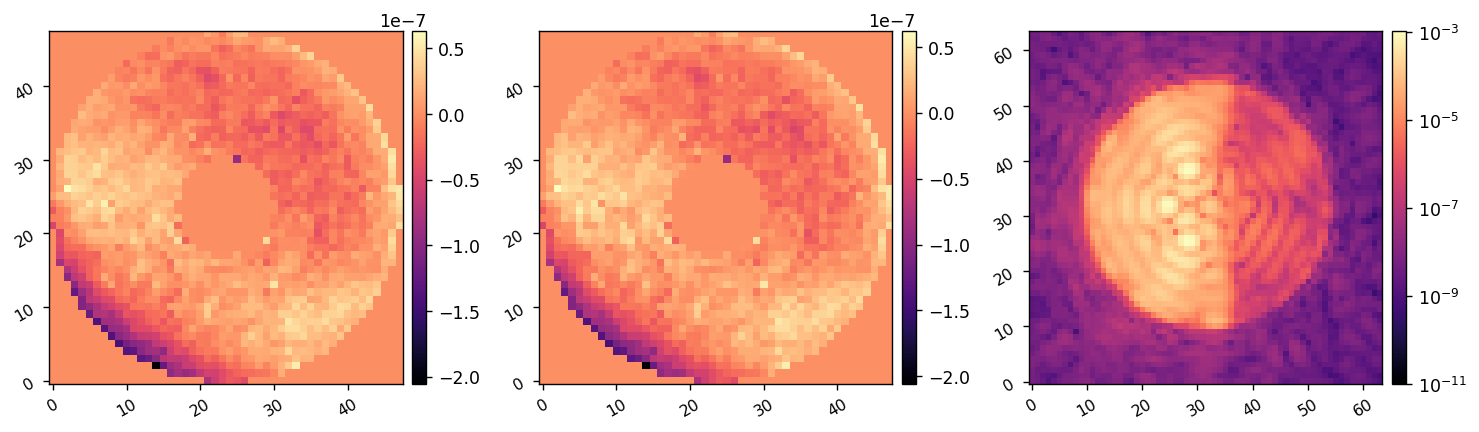

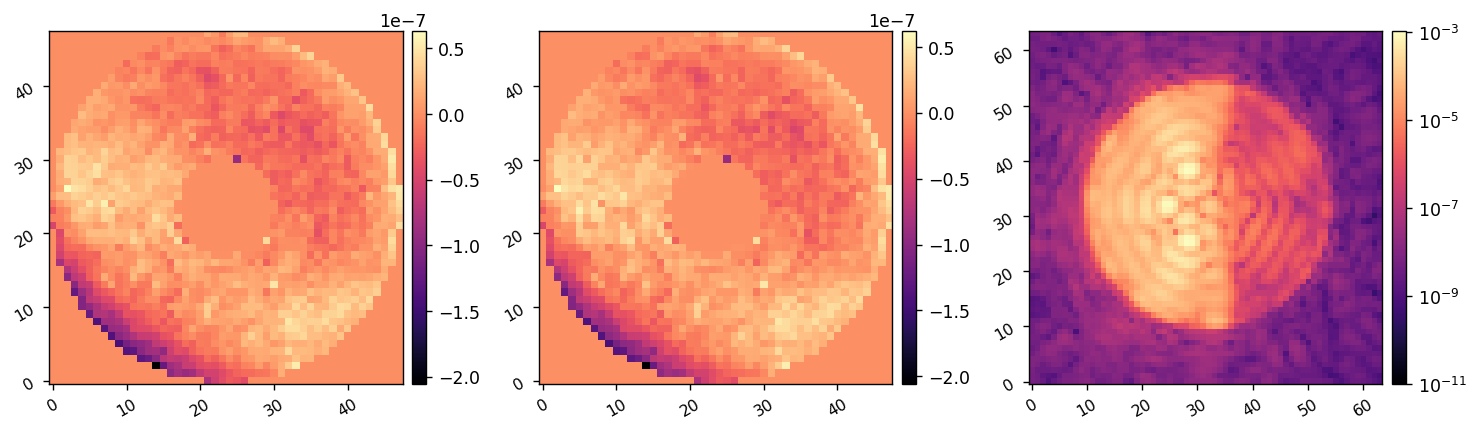

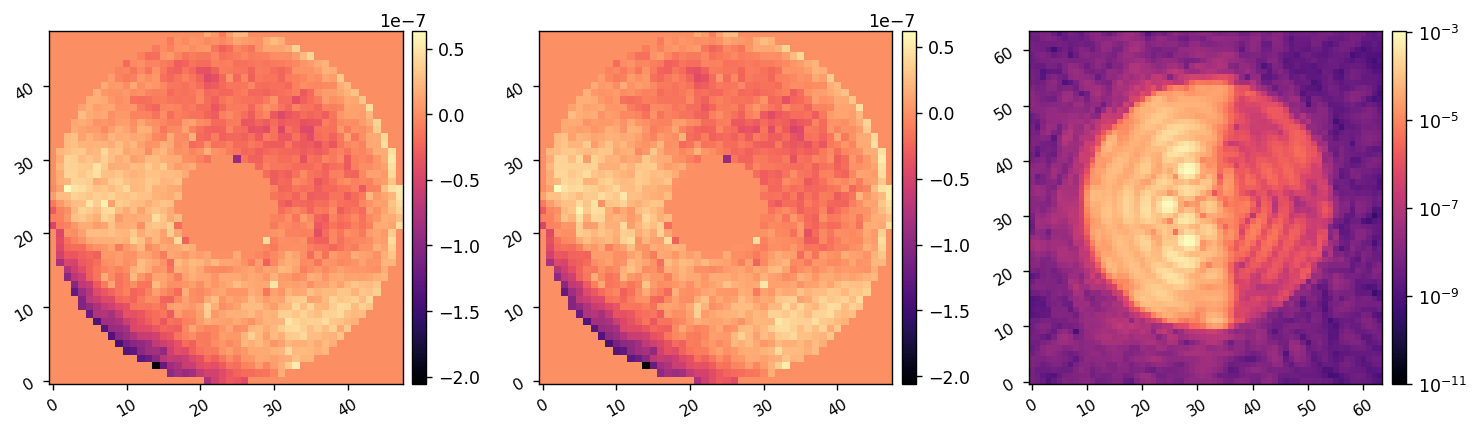

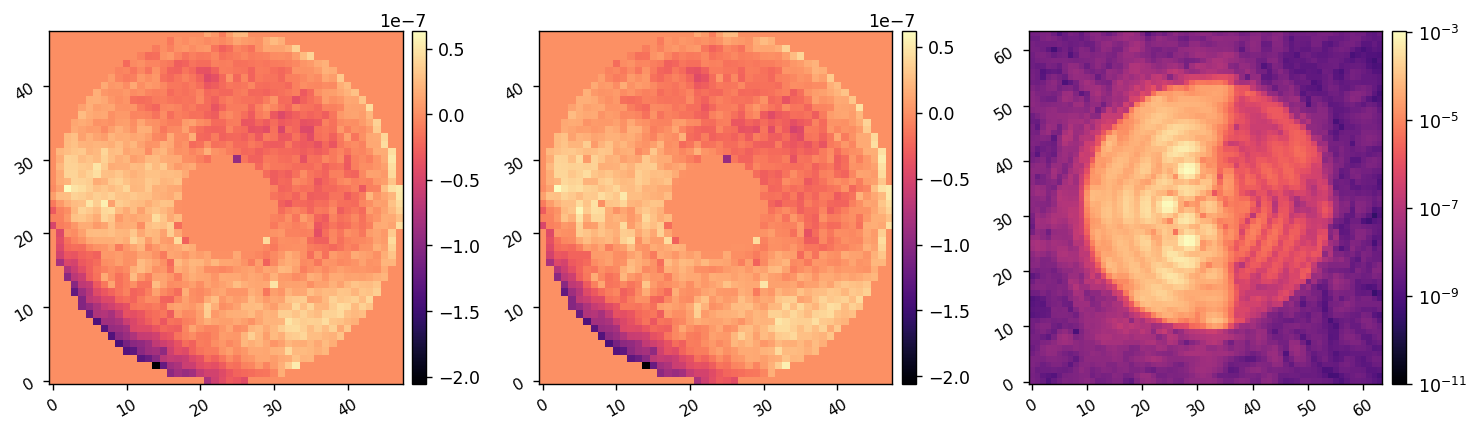

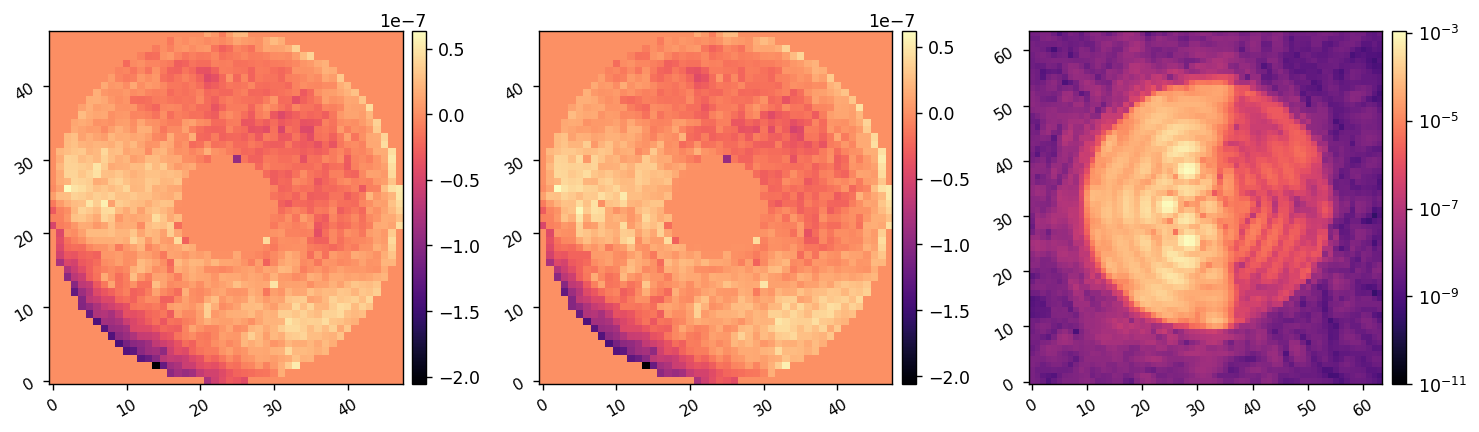

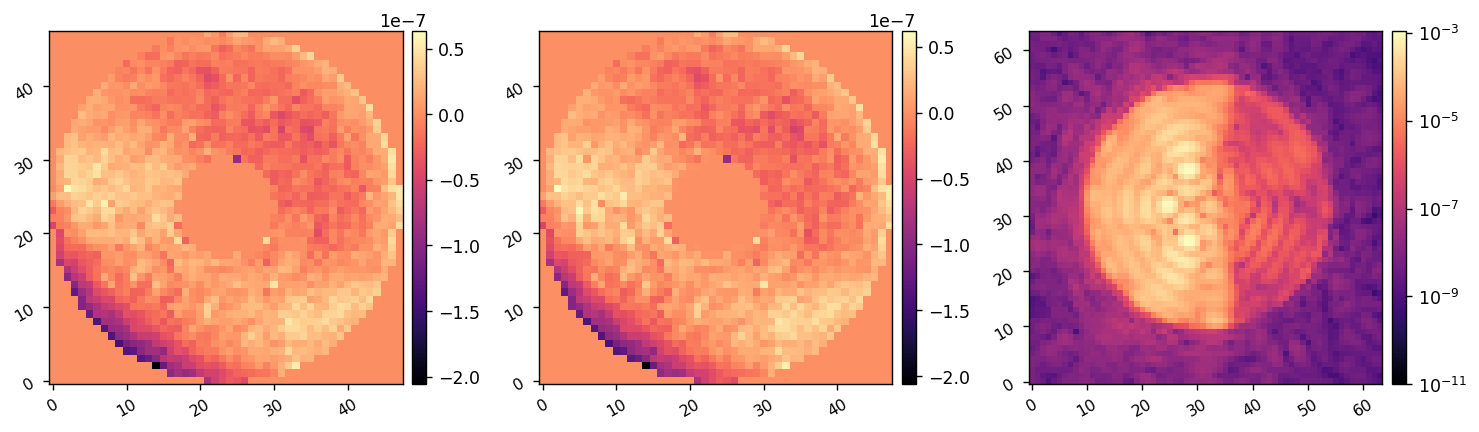

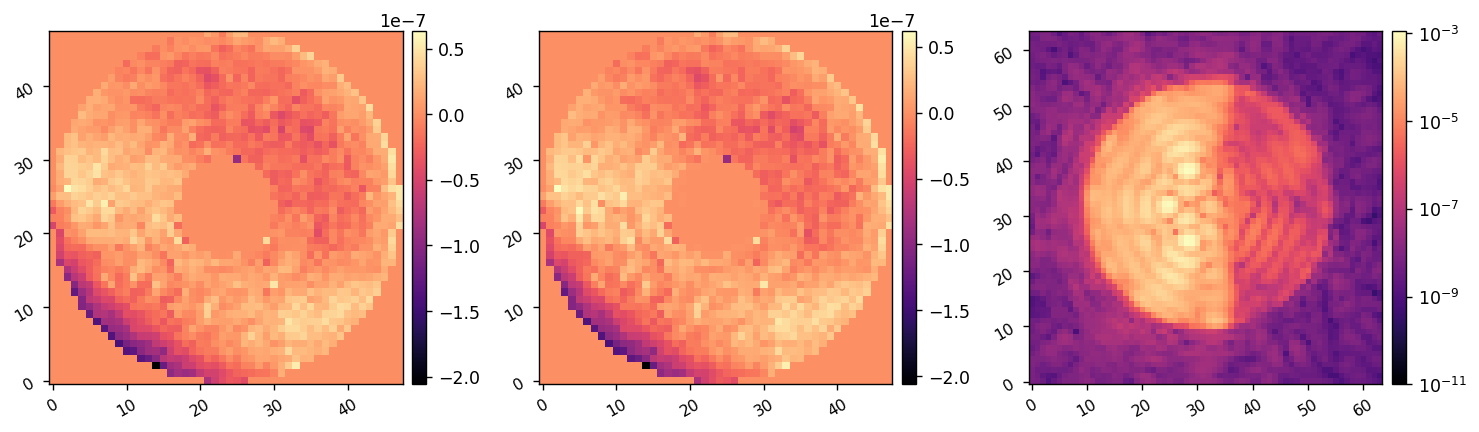

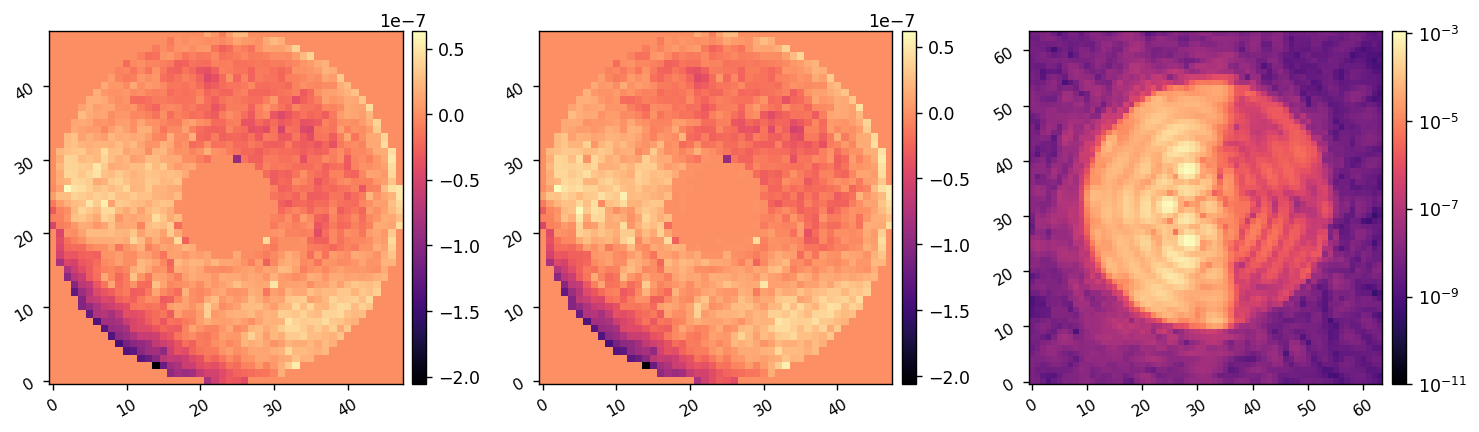

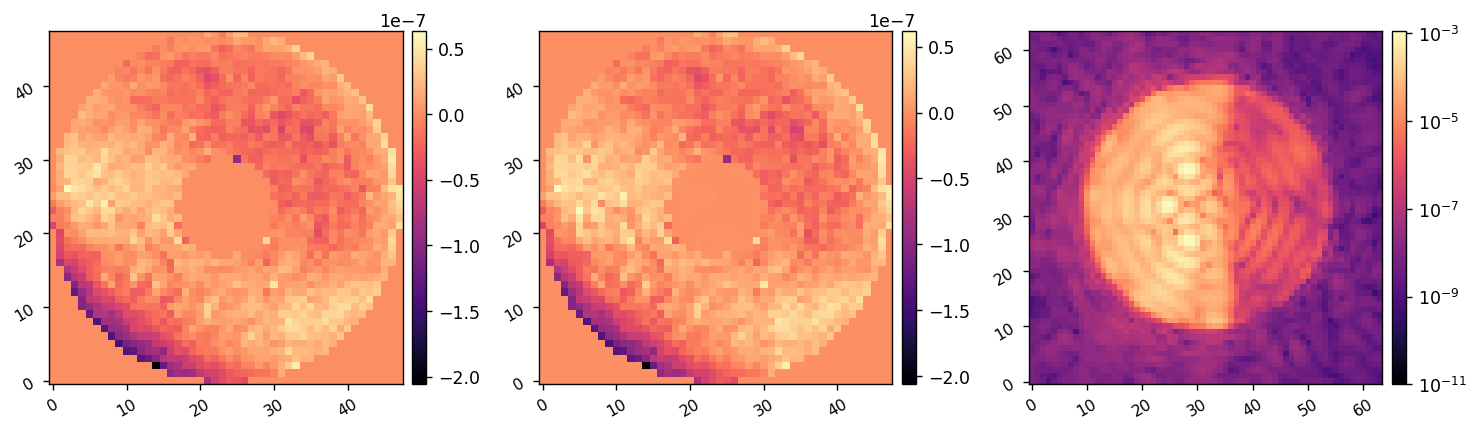

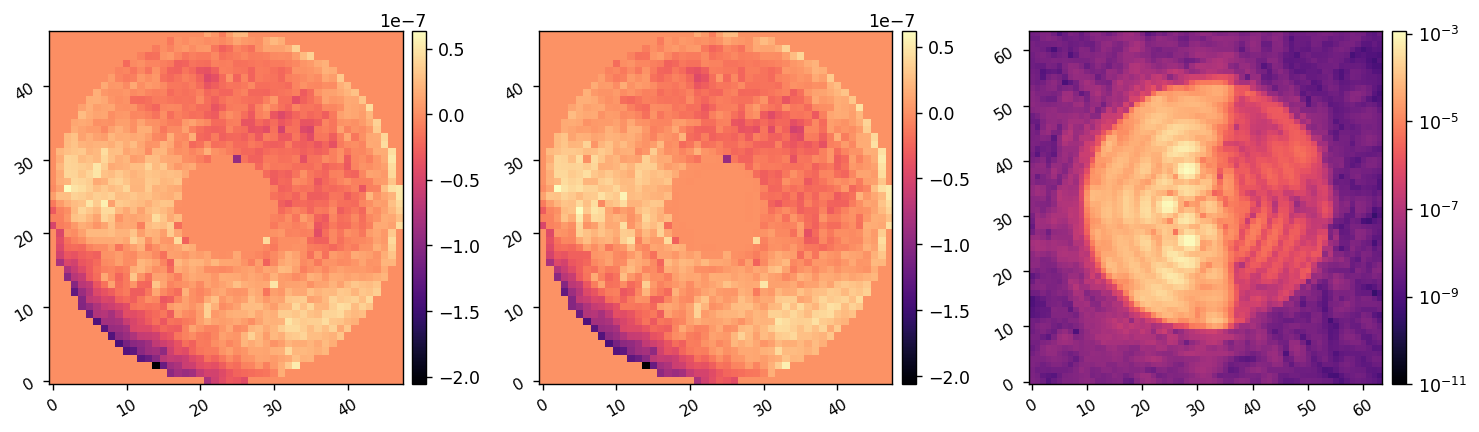

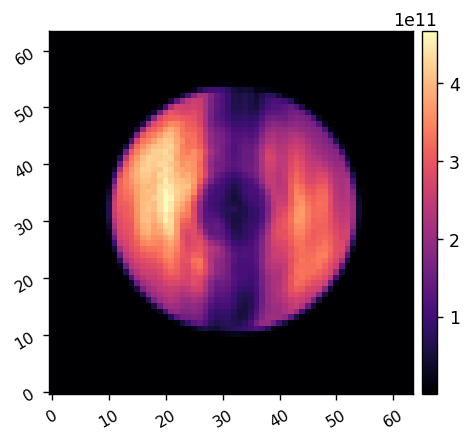

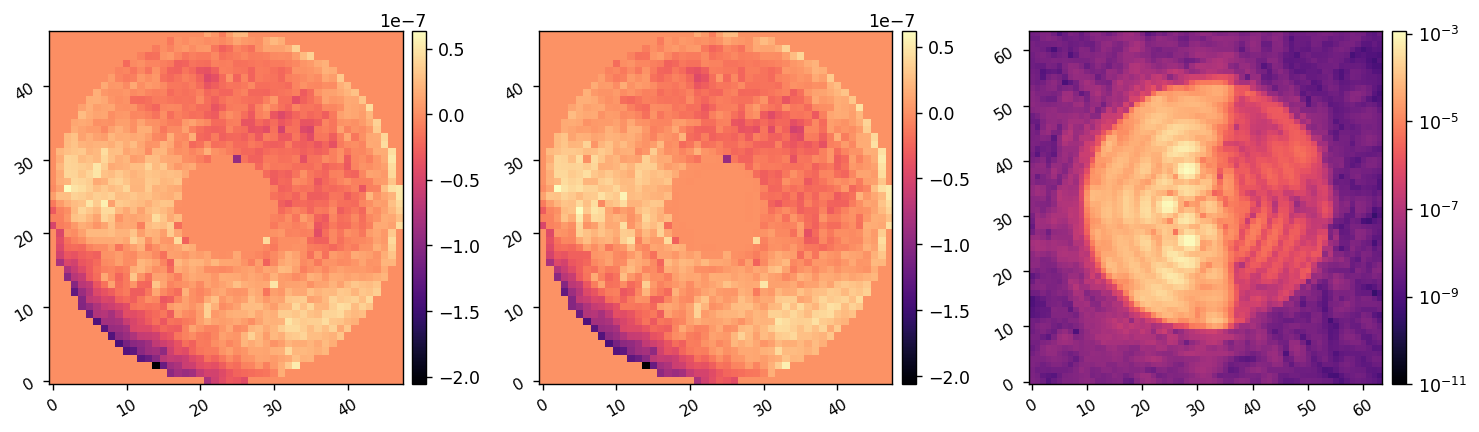

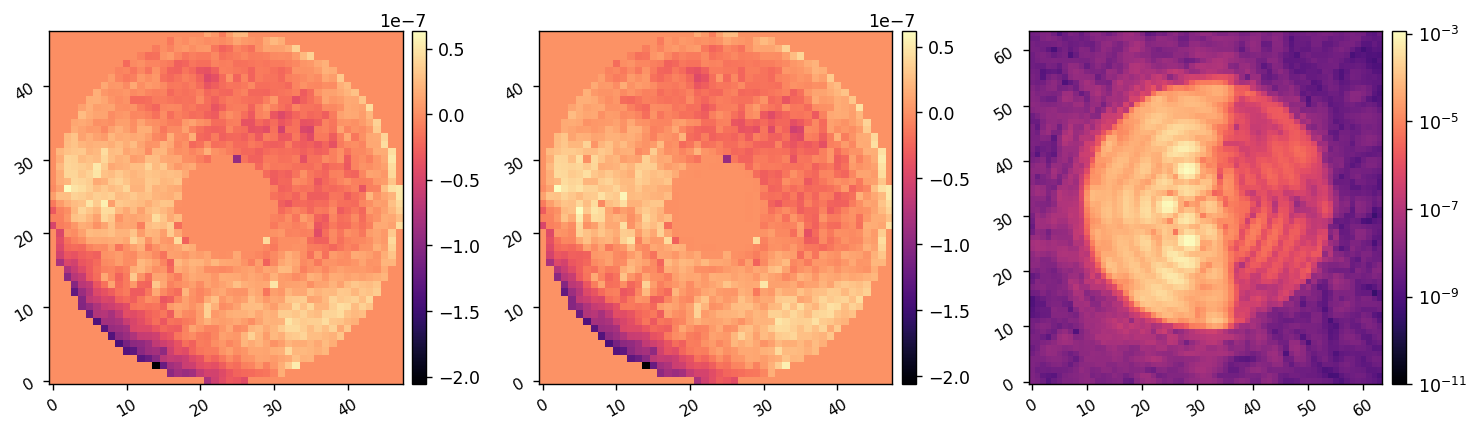

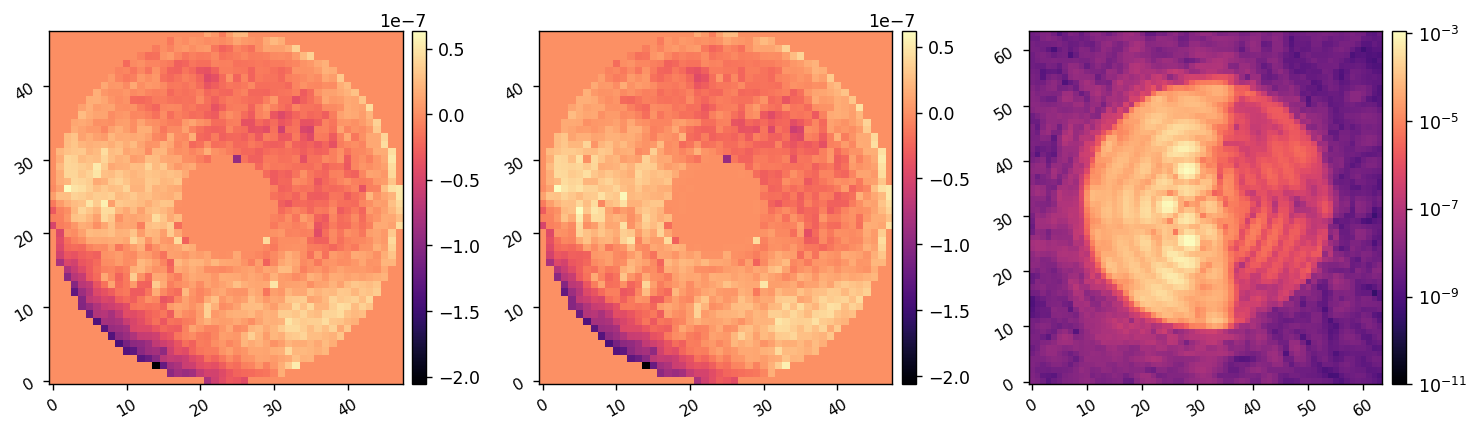

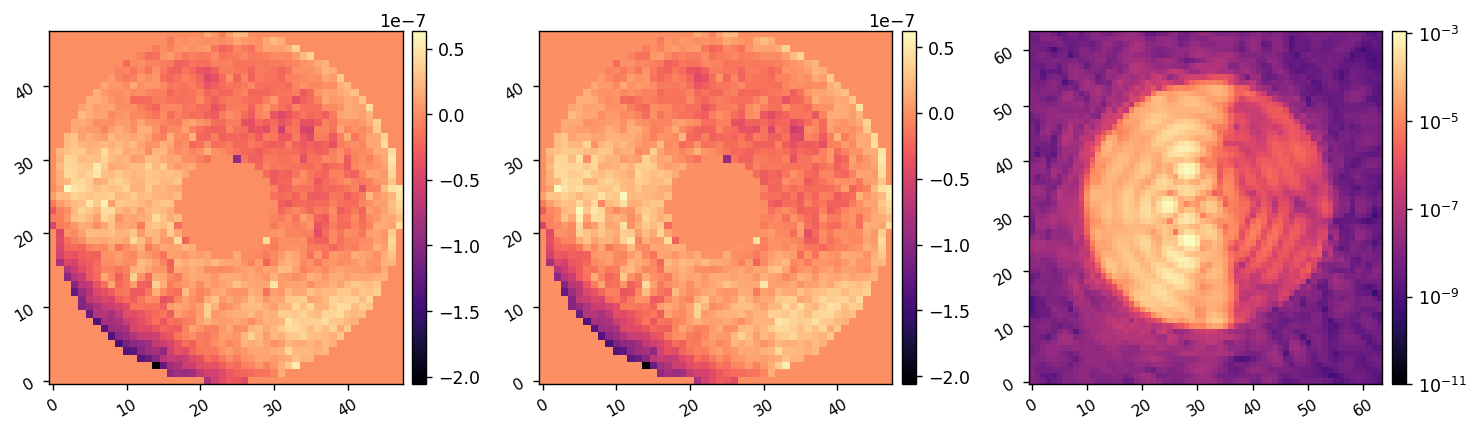

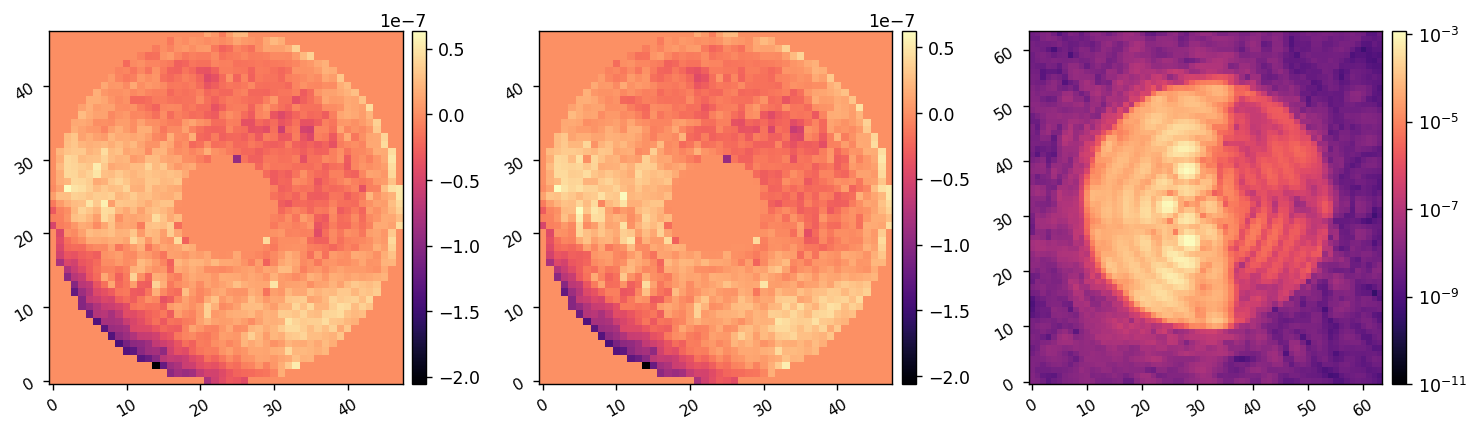

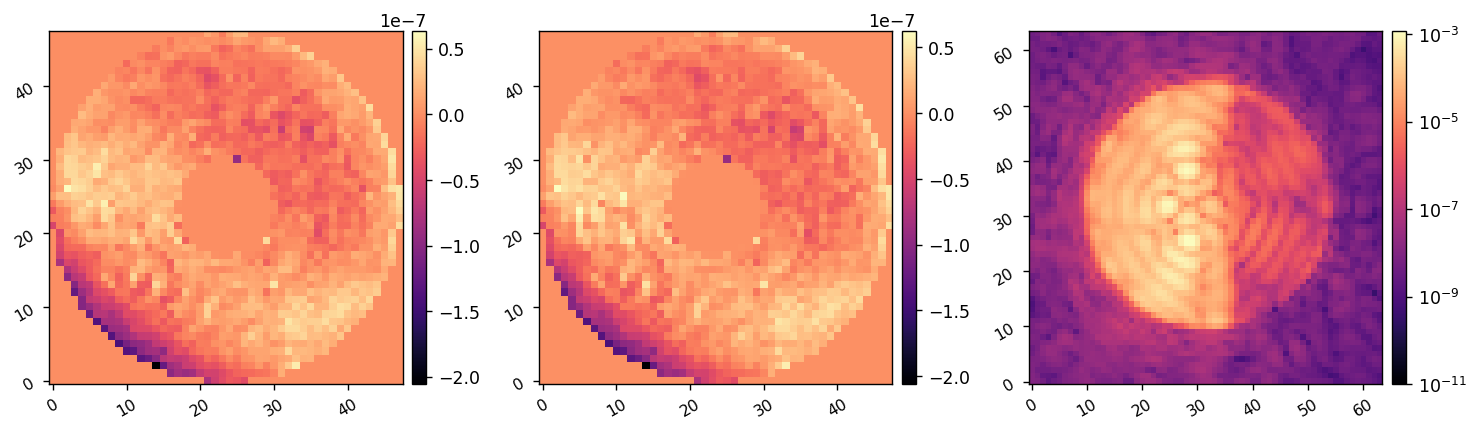

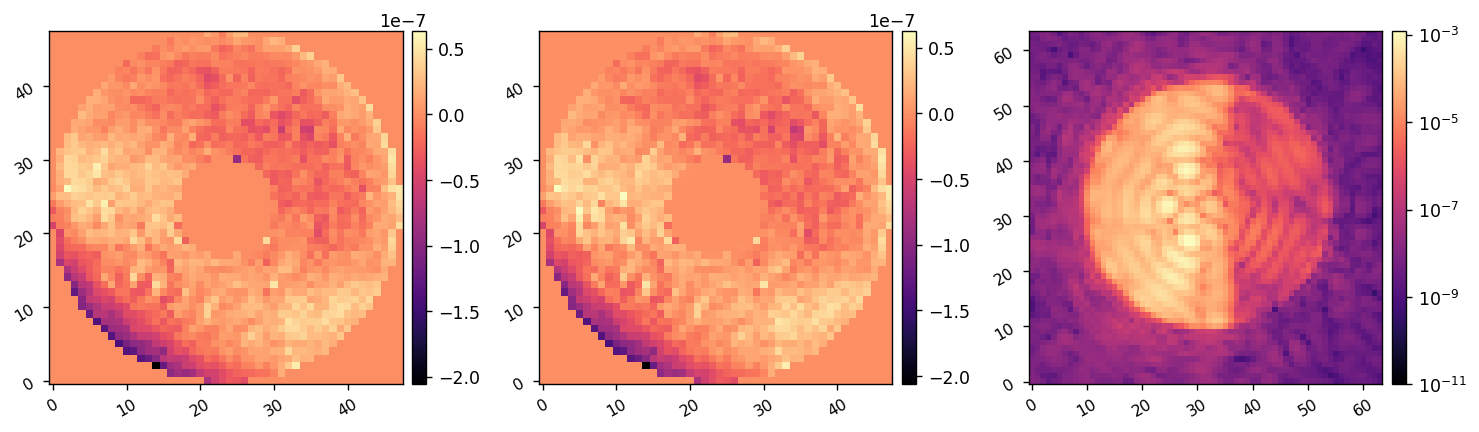

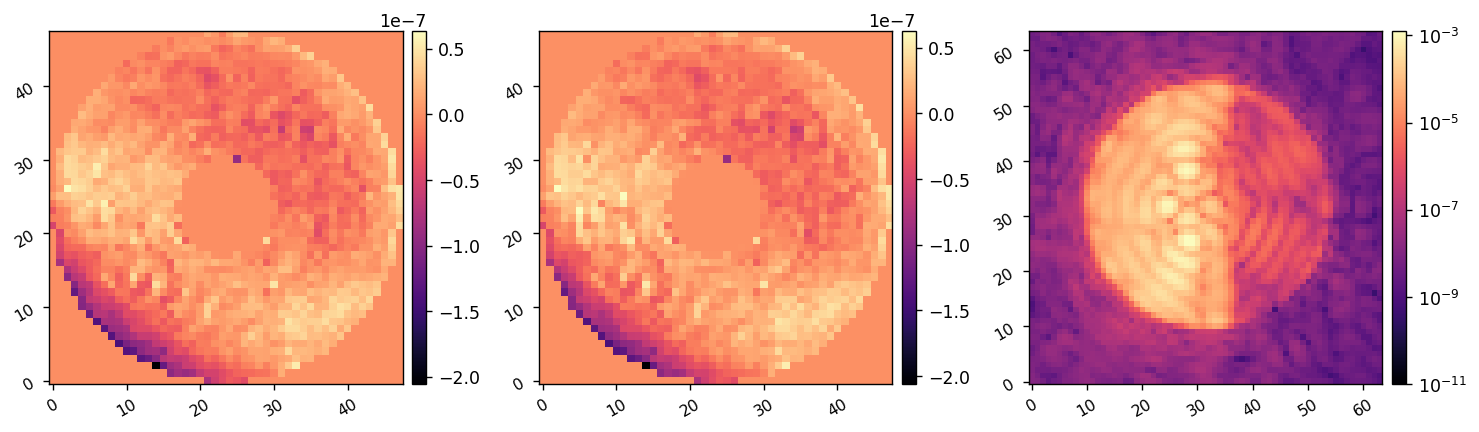

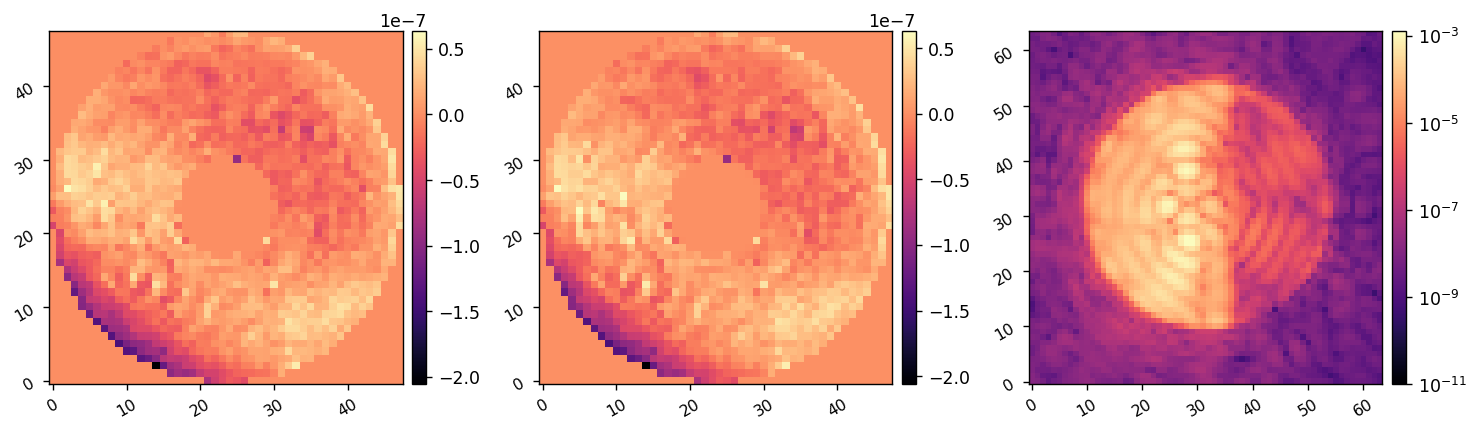

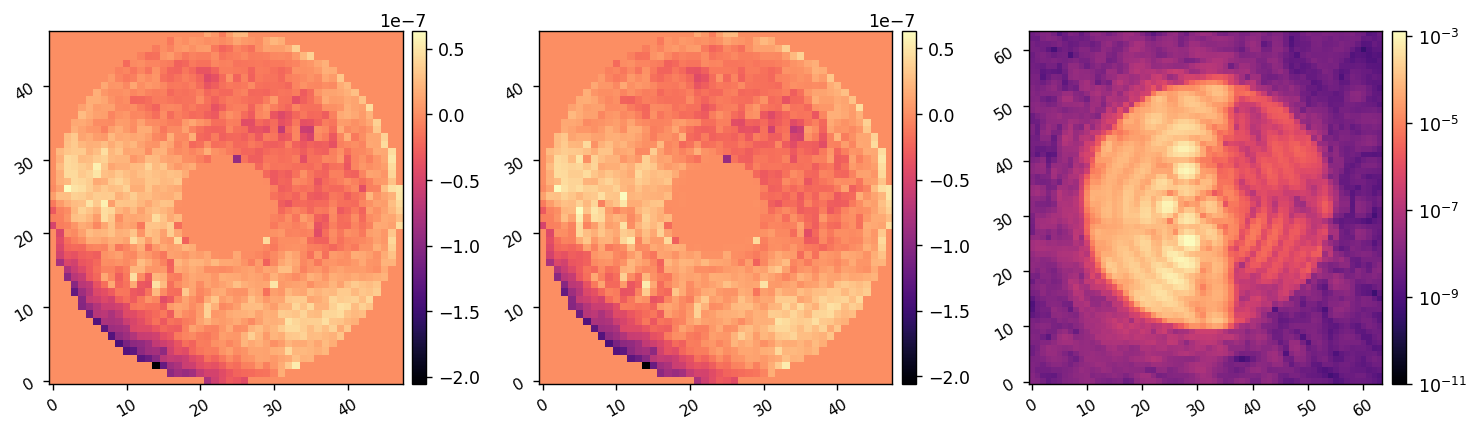

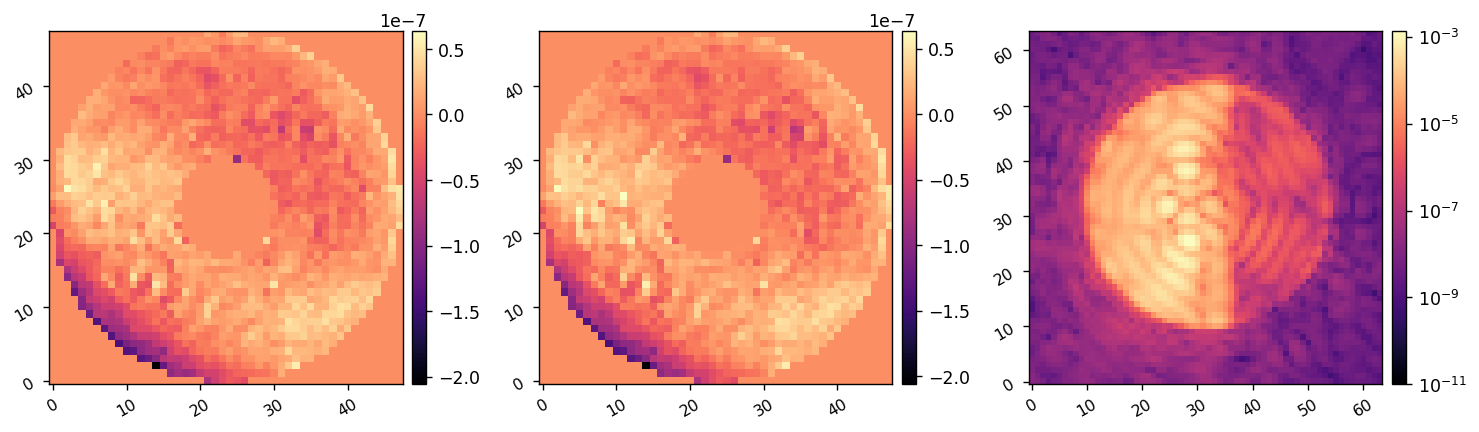

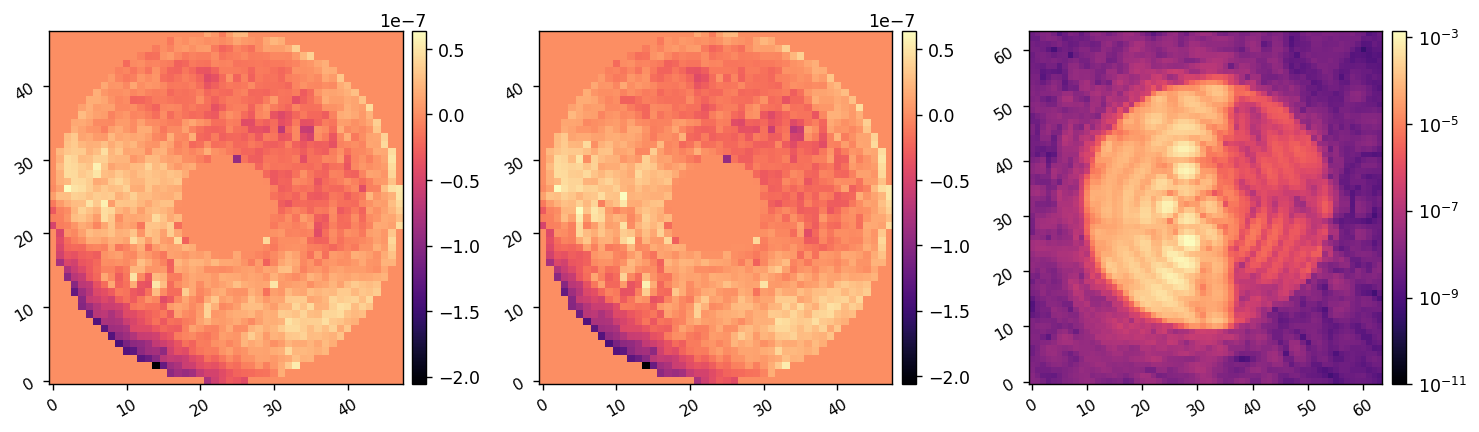

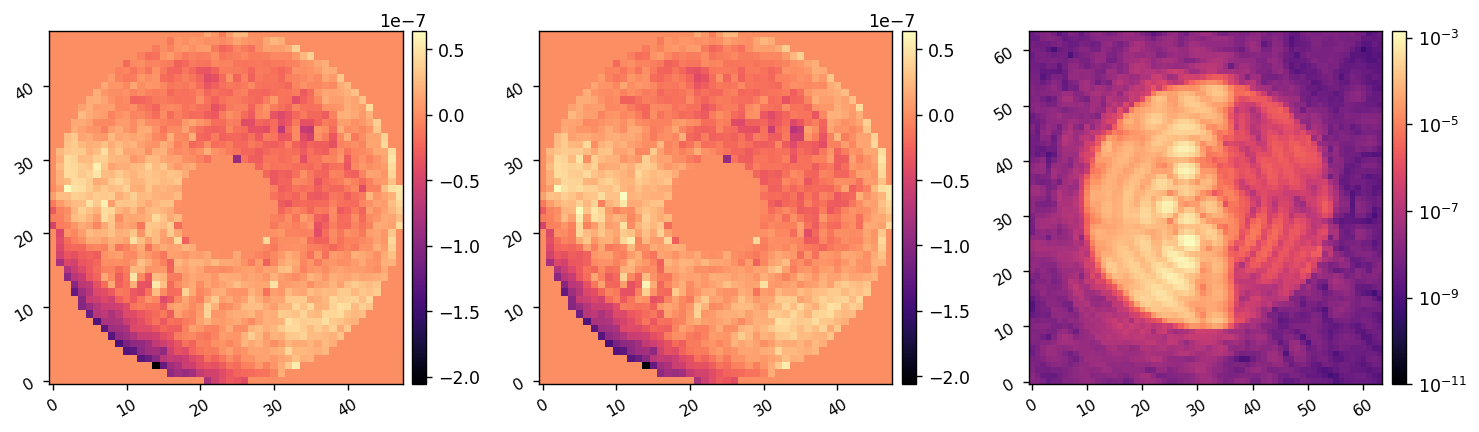

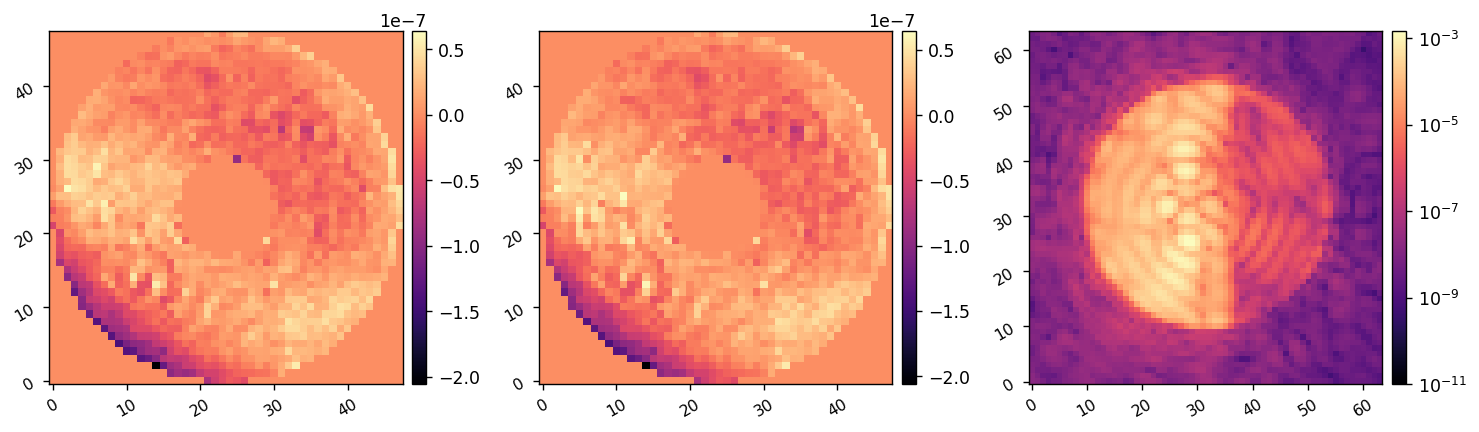

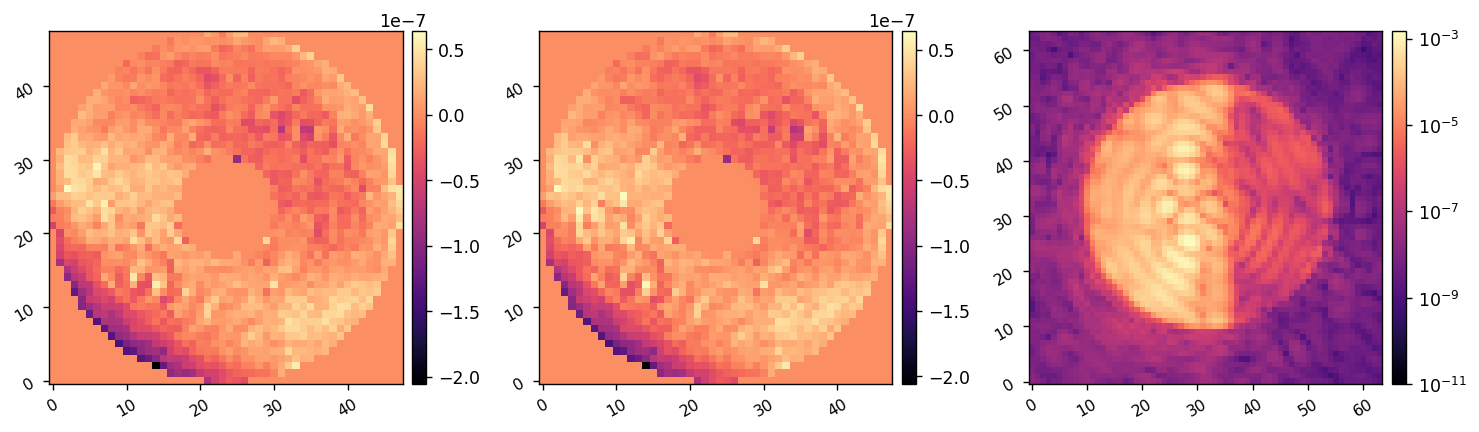

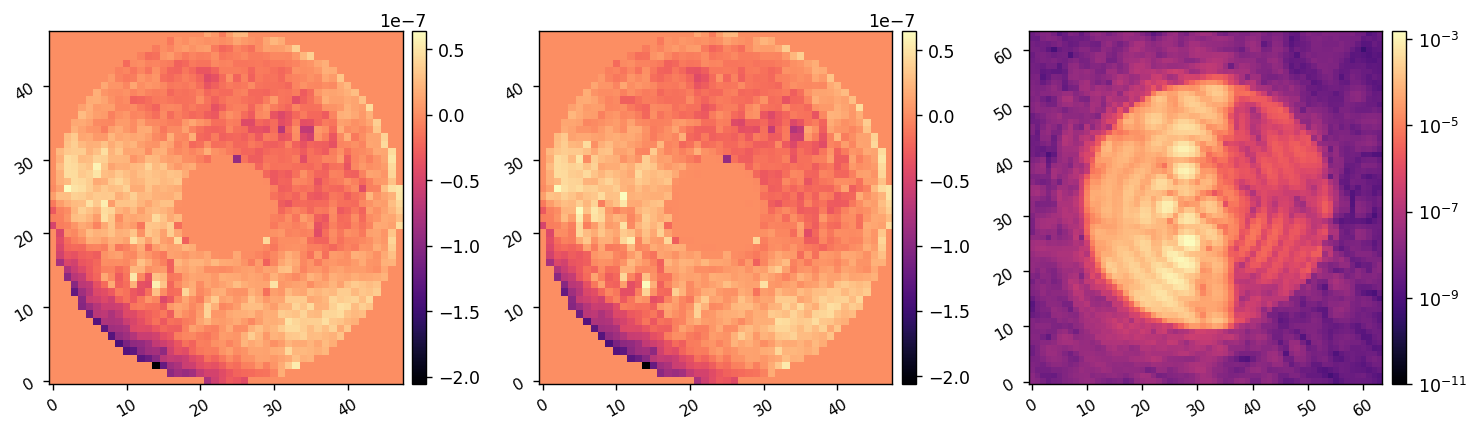

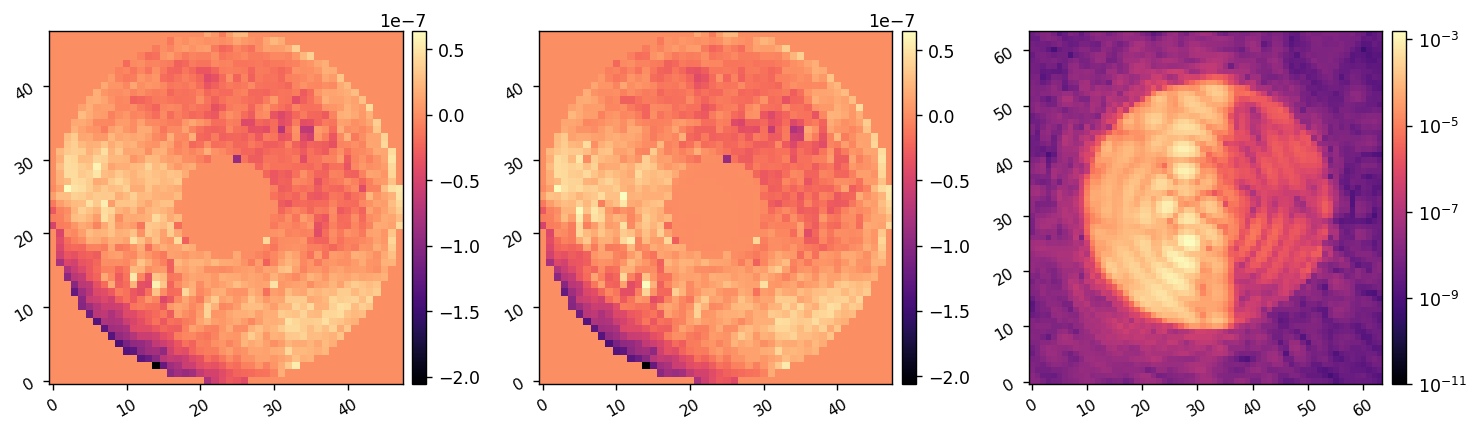

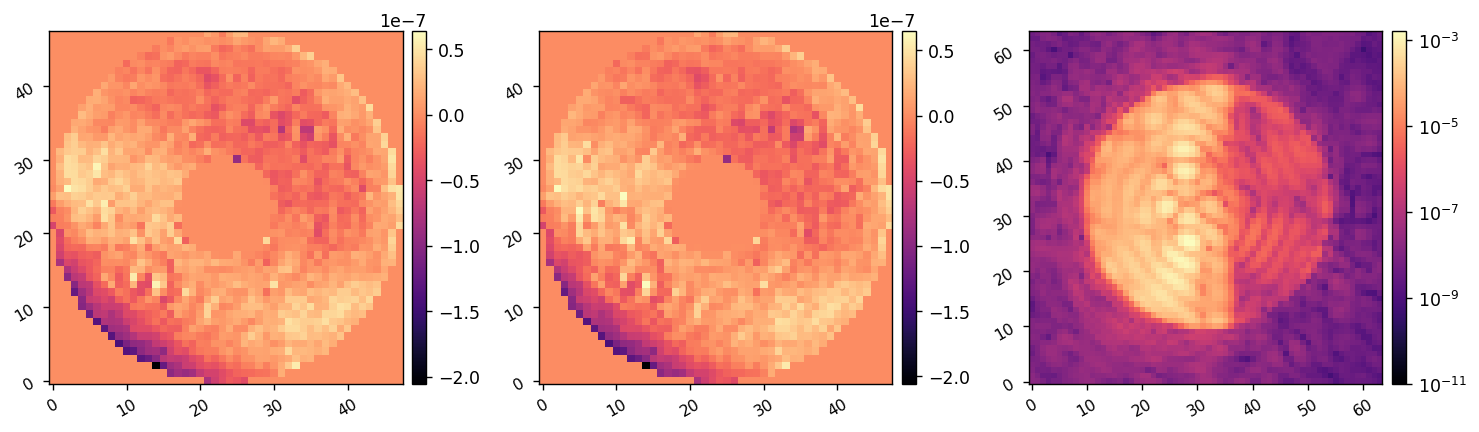

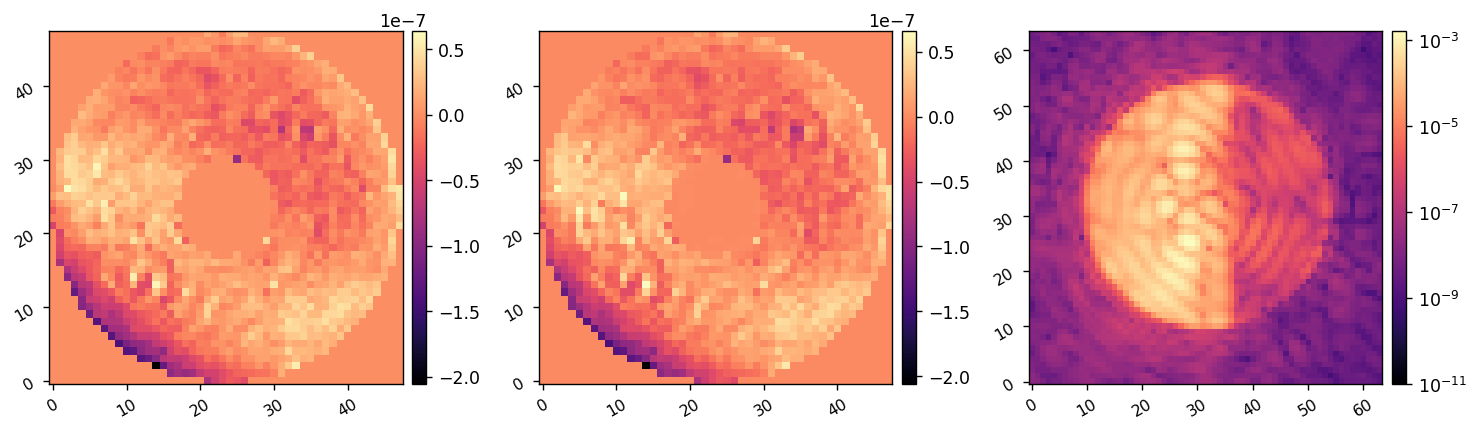

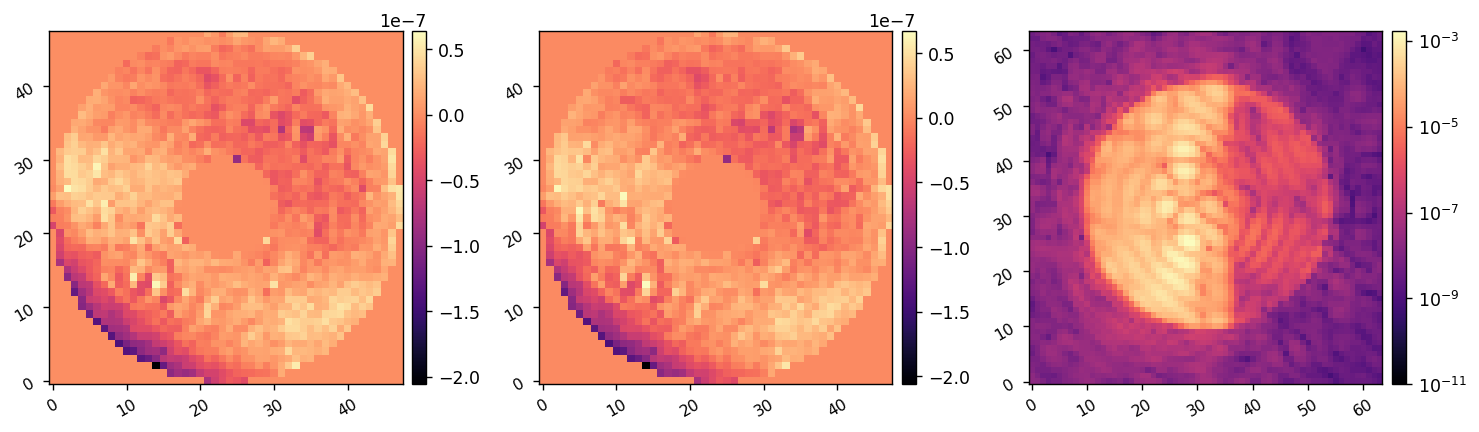

In [11]:
date = 20230711
Ncalibs = 2
Nitr = 20
for i in range(Ncalibs):
    response_cube = xp.array(fits.getdata(iefc_dir/'response-data'/f'hlcbb_iefc_2dm_poke_response_cube_{date}_calib{i+1}.fits'))
    fp_response = xp.sqrt(xp.sum(abs(response_cube)**2, axis=(0,1))).reshape(mode.npsf,mode.npsf)
    wfsc.imshow1(fp_response)
    
    images = fits.getdata(iefc_dir/'images'/f'hlcbb_iefc_2dm_poke_images_{date}_calib{i+1}.fits')
    dm1_commands = fits.getdata(iefc_dir/'dm-commands'/f'hlcbb_iefc_2dm_poke_dm1_commands_{date}_calib{i+1}.fits')
    dm2_commands = fits.getdata(iefc_dir/'dm-commands'/f'hlcbb_iefc_2dm_poke_dm2_commands_{date}_calib{i+1}.fits')
    for i in range(Nitr):
        wfsc.imshow3(dm1_commands[i], dm2_commands[i], images[i], lognorm3=True, vmin3=1e-11)